In [23]:
import os
from tensorflow import keras
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,MaxPooling2D,Conv2D,Dropout,Activation,BatchNormalization
import pathlib
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt

Load the data into two sets:

In [24]:
data_folder = pathlib.Path("C:/Users/yatch/Desktop/Advanced Applied Mathematical concept of Machine learning/xray_dataset_covid19")

In [25]:
train = data_folder/"train"
test = data_folder/"test"

In [26]:
classes_train=os.listdir(train)
classes_test=os.listdir(test)

In [27]:
print(classes_train)
print(classes_test)

['NORMAL', 'PNEUMONIA']
['NORMAL', 'PNEUMONIA']


In [28]:
train_datagen=ImageDataGenerator(
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=1.0/255,
    width_shift_range=0.10,
    height_shift_range=0.10,
    shear_range=0.1
)
train_generator=train_datagen.flow_from_directory(
    train,
    class_mode='binary',
    color_mode='rgb',
    batch_size=32,
    target_size=(248,248,3)[:2]
)


Found 148 images belonging to 2 classes.


In [29]:
test_datagen=ImageDataGenerator(
    rescale=1.0/255
)
test_generator=test_datagen.flow_from_directory(
    test,
    class_mode='binary',
    color_mode='rgb',
    batch_size=32,
    target_size=(248,248,3)[:2]
)

Found 40 images belonging to 2 classes.


### Definning the model

### Using data augmentation

**Define a data augmentation stage to add to an image model**

**Defining a new convnet that includes image augmentation and dropout**

In [60]:
model=Sequential() 
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(248,248,3)))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(256,(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss="binary_crossentropy",
              optimizer="Adam",
              metrics=["accuracy"])

In [61]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 246, 246, 32)      896       
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 123, 123, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 121, 121, 64)      18496     
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 60, 60, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 58, 58, 128)       73856     
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 29, 29, 128)     

**Training the regularized convnet**

In [62]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    train_generator,
    epochs=30,
    validation_data=test_generator,
    callbacks=callbacks)

Epoch 1/30
5/5 [==============================] - 19s 4s/step - loss: 0.7805 - accuracy: 0.4730 - val_loss: 0.6874 - val_accuracy: 0.5000
Epoch 2/30
5/5 [==============================] - 18s 4s/step - loss: 0.6905 - accuracy: 0.5068 - val_loss: 0.6798 - val_accuracy: 0.5000
Epoch 3/30
5/5 [==============================] - 18s 4s/step - loss: 0.6803 - accuracy: 0.6149 - val_loss: 0.6437 - val_accuracy: 0.5000
Epoch 4/30
5/5 [==============================] - 18s 4s/step - loss: 0.6441 - accuracy: 0.6081 - val_loss: 0.5204 - val_accuracy: 0.6750
Epoch 5/30
5/5 [==============================] - 18s 3s/step - loss: 0.5533 - accuracy: 0.7230 - val_loss: 0.2662 - val_accuracy: 0.9250
Epoch 6/30
5/5 [==============================] - 19s 4s/step - loss: 0.3920 - accuracy: 0.8446 - val_loss: 0.1032 - val_accuracy: 0.9250
Epoch 7/30
5/5 [==============================] - 17s 3s/step - loss: 0.2546 - accuracy: 0.8919 - val_loss: 0.1187 - val_accuracy: 0.9750
Epoch 8/30
5/5 [==================

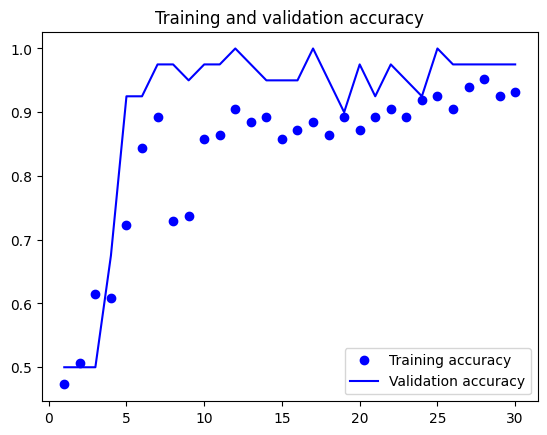

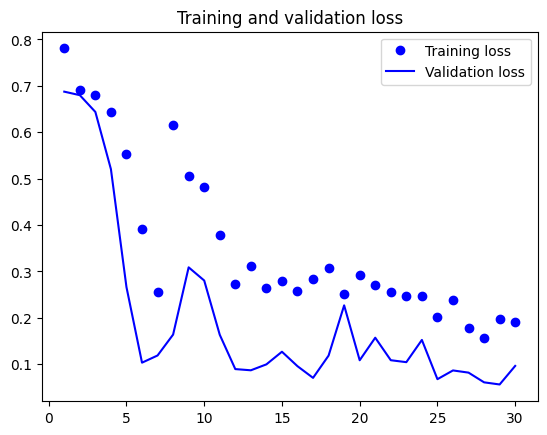

In [63]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Here an overfit is much less evident. Based on the validation accuracy it might have been reached only towards the last few epoches. Though the vaidation loss, while noisy, starts to increase after the 83th epoch or so.

Prediction

In [64]:
def plot_prediction(test_generator, n_images):
    """
    Test the model on random predictions
    Args:
    generator: a generator instance
    n_images : number of images to plot

    """
    i = 1
    class_names=['NORMAL','PNEUMONIA']
    images, labels = test_generator.next()
    predictions = np.argmax(model.predict(images), axis=1)
    labels = labels.astype('int32')
    plt.figure(figsize=(14, 15))
    for image, label in zip(images, labels):
        plt.subplot(4, 3, i)
        plt.imshow(image)
        if predictions[i] == labels[i]:
            title_obj = plt.title(class_names[label])
            plt.setp(title_obj, color='g') 
            plt.axis('off')
        else:
            title_obj = plt.title(class_names[label])
            plt.setp(title_obj, color='r') 
            plt.axis('off')
        i += 1
        if i == n_images:
            break

    plt.show()

1/1 [==============================] - 0s 312ms/step


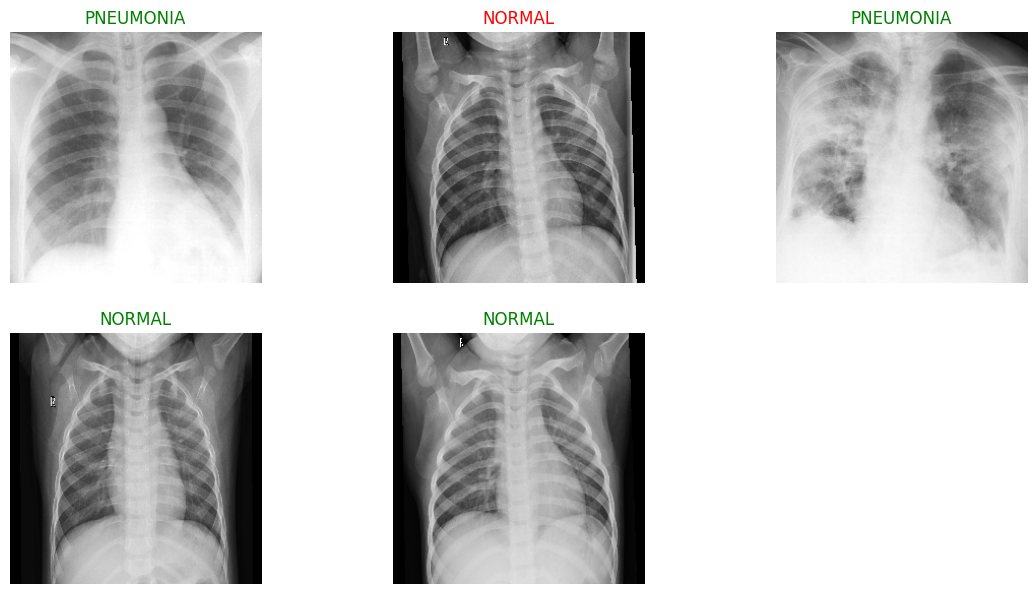

In [68]:
plot_prediction(test_generator,6)

### Transfer Learning

VGG16 model

In [69]:
import random
# Set a random seed for reproducibility
random_seed = 42
random.seed(random_seed)
tf.random.set_seed(random_seed)
    
vgg_model = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(248, 248, 3))

In [70]:
vgg_model.trainable = True
for layer in vgg_model.layers[:-4]:
    layer.trainable = False
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 248, 248, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 248, 248, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 248, 248, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 124, 124, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 124, 124, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 124, 124, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 62, 62, 128)       0     

In [72]:
model = Sequential()
model.add(vgg_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))

In [73]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_6 (Flatten)         (None, 25088)             0         
                                                                 
 dense_12 (Dense)            (None, 256)               6422784   
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 1)                 257       
                                                                 
Total params: 21,137,729
Trainable params: 13,502,465
Non-trainable params: 7,635,264
_________________________________________________________________


In [74]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="./models/feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator,
    callbacks=callbacks)


Epoch 1/10
5/5 [==============================] - 35s 7s/step - loss: 0.6779 - accuracy: 0.6081 - val_loss: 0.4772 - val_accuracy: 0.9250
Epoch 2/10
5/5 [==============================] - 35s 7s/step - loss: 0.5474 - accuracy: 0.7095 - val_loss: 0.3435 - val_accuracy: 0.9000
Epoch 3/10
5/5 [==============================] - 28s 6s/step - loss: 0.3946 - accuracy: 0.8581 - val_loss: 0.2784 - val_accuracy: 0.9250
Epoch 4/10
5/5 [==============================] - 28s 6s/step - loss: 0.3064 - accuracy: 0.9122 - val_loss: 0.2188 - val_accuracy: 0.9500
Epoch 5/10
5/5 [==============================] - 28s 6s/step - loss: 0.3077 - accuracy: 0.8784 - val_loss: 0.1765 - val_accuracy: 0.9500
Epoch 6/10
5/5 [==============================] - 29s 6s/step - loss: 0.2466 - accuracy: 0.9257 - val_loss: 0.1547 - val_accuracy: 0.9250
Epoch 7/10
5/5 [==============================] - 28s 6s/step - loss: 0.2144 - accuracy: 0.9392 - val_loss: 0.1390 - val_accuracy: 0.9750
Epoch 8/10
5/5 [==================

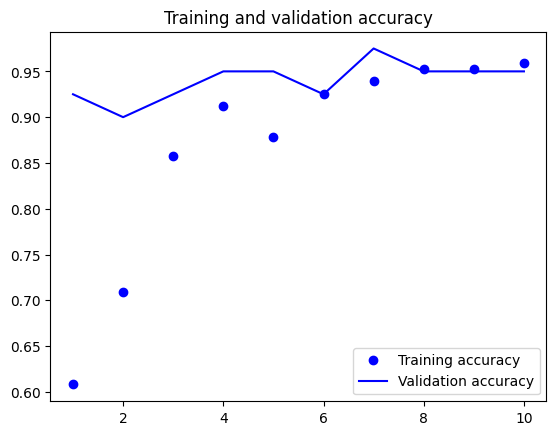

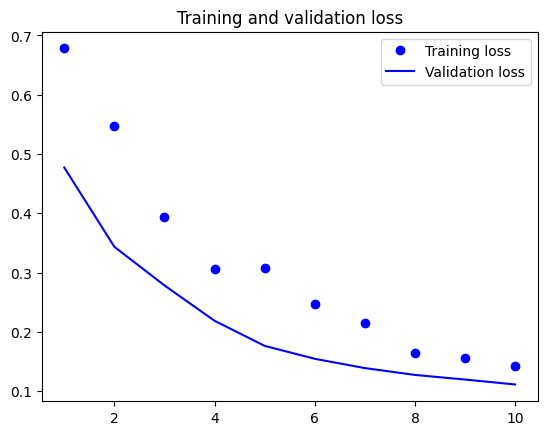

In [75]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Prediction

In [76]:
def plot_prediction(test_generator, n_images):
    """
    Test the model on random predictions
    Args:
    generator: a generator instance
    n_images : number of images to plot

    """
    i = 1
    class_names=['NORMAL','PNEUMONIA']
    images, labels = test_generator.next()
    predictions = np.argmax(model.predict(images), axis=1)
    labels = labels.astype('int32')
    plt.figure(figsize=(14, 15))
    for image, label in zip(images, labels):
        plt.subplot(4, 3, i)
        plt.imshow(image)
        if predictions[i] == labels[i]:
            title_obj = plt.title(class_names[label])
            plt.setp(title_obj, color='g') 
            plt.axis('off')
        else:
            title_obj = plt.title(class_names[label])
            plt.setp(title_obj, color='r') 
            plt.axis('off')
        i += 1
        if i == n_images:
            break

    plt.show()

1/1 [==============================] - 1s 1s/step


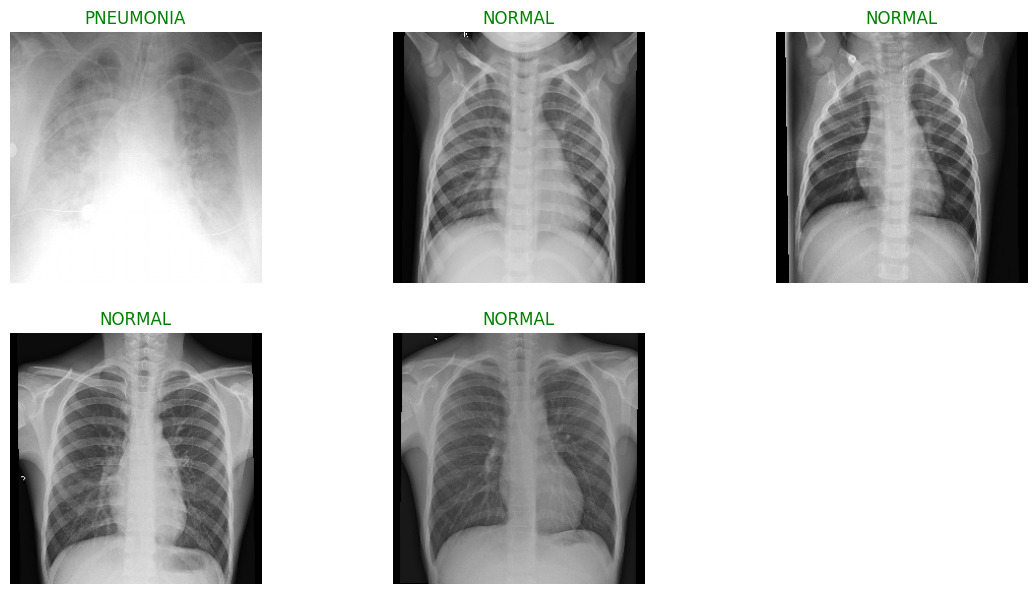

In [77]:
plot_prediction(test_generator, n_images=6)

### Discussion

Let's compare the key aspects between two model trained:

Model Architecture:
First Model: It's a custom CNN with multiple convolutional, max pooling, and fully connected layers, ending in a single sigmoid activation unit for binary classification.
Second Model: Utilizes the VGG16 architecture with the addition of a flattening layer, a dense layer with 256 units, a dropout layer for regularization, and a final dense layer with a sigmoid activation function for binary classification.

Parameters:
First Model: Has a smaller number of parameters compared to the VGG16-based model. This can lead to faster training times but may not capture as complex features as the VGG16 model.
Second Model: Has a significant number of parameters, most of which come from the VGG16 base. This can capture more complex features and might generalize better, assuming it's not overfitting.

Performance:
First Model: Shows high training and validation accuracies that stabilize around 95% for training and fluctuate slightly on validation but also high. The training and validation loss graphs indicate the model has learned to generalize well from the training data.
Second Model: Also demonstrates high training accuracy, reaching approximately 95%, with validation accuracy slightly lower. The training loss decreases consistently, but the validation loss shows more variance, potentially indicating some overfitting despite the regularization applied.

Convergence:
First Model: Seems to have converged well, as seen in the loss graph where both training and validation losses decrease over time.
Second Model: Shows rapid convergence within 10 epochs, which is typical for transfer learning models since they leverage pre-learned weights. The validation loss, however, does not decrease as smoothly, which suggests that the model could benefit from additional regularization or hyperparameter tuning.

Predictions:
First Model: Based on the provided images, it's not clear how many predictions were correct, but the images imply that the predictions were visualized and potentially accurate.
Second Model: There's a warning about some calls to the prediction function, which might suggest there were some issues during prediction. However, from the last image provided, it seems the predictions are generally accurate.

In summary, the second model with transfer learning from VGG16 seems to achieve high accuracy faster due to the pre-trained weights. However, it may be slightly overfitting as evidenced by the variance in the validation loss. It might be beneficial to include additional regularization techniques or data augmentation to improve its generalization capabilities. On the other hand, the first model, while having fewer parameters and possibly being less complex, also shows good performance and generalization. The choice between the two models could depend on factors like the size of the dataset, computational resources, and the specific requirements of the application.